Download the data

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2019-07-29 01:44:36--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.88.122, 99.86.88.47, 99.86.88.50, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.88.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.7’

data.zip.7          100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2019-07-29 01:44:36 (28.0 MB/s) - ‘data.zip.7’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/na

In [0]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.8*len(lines)))]
    test_data[category] = lines[int(math.floor(0.8*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Spanish.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Korean.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/French.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Polish.txt', 'data/names/Vietnamese.txt', 'data/names/Dutch.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [0]:
print(category_lines['Italian'][:5])

['Capello', 'Aita', 'Abate', 'De vitis', 'Capello']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [5]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [0]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(hidden)

tensor([[-2.8769, -2.9111, -2.8236, -2.8744, -2.9096, -2.7822, -2.8050, -2.9239,
         -2.8475, -2.9278, -2.8899, -2.7965, -3.0097, -2.9365, -2.9608, -2.9986,
         -2.9695, -2.8239]], grad_fn=<LogSoftmaxBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 5)


We will also want a quick way to get a training example (a name and its
language):




In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Gagliardi
category = Spanish / line = Lobo
category = German / line = Achilles
category = Irish / line = Lennon
category = Dutch / line = Rumpade
category = German / line = Bohmer
category = English / line = Grennan
category = Japanese / line = Yamaguchi
category = Polish / line = Rudaski
category = Scottish / line = Robertson


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [0]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [0]:
from torch import optim

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
#optimizer = optim.Adam(rnn.parameters(), lr=learning_rate) #for defining my optimizer when not using train_GRU

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    
    #optimizer.step()
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_test_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output
  
  
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
  
  
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_test_losses.append(test_loss.item() / n_test_instances)


5000 5% (0m 23s) 2.3048 Maolmhuaidh / Greek ✗ (Irish)
10000 10% (0m 50s) 1.3635 Ahn / Chinese ✗ (Korean)
15000 15% (1m 17s) 2.6574 Marshall / Japanese ✗ (Scottish)
20000 20% (1m 44s) 0.0202 Yamakazi / Japanese ✓
25000 25% (2m 11s) 1.5165 Kavanagh / Japanese ✗ (Irish)
30000 30% (2m 39s) 2.6475 Kara / Japanese ✗ (Czech)
35000 35% (3m 6s) 2.5536 Sekovora / Japanese ✗ (Czech)
40000 40% (3m 33s) 1.7654 Sarkis / Greek ✗ (Arabic)
45000 45% (4m 1s) 0.0500 Lawniczak / Polish ✓
50000 50% (4m 29s) 0.6870 Vinh / Vietnamese ✓
55000 55% (4m 56s) 0.1212 Tunnikov / Russian ✓
60000 60% (5m 24s) 0.5420 Handal / Arabic ✓
65000 65% (5m 51s) 1.6889 Mach / Scottish ✗ (Vietnamese)
70000 70% (6m 27s) 2.5618 Caiazzo / Portuguese ✗ (Italian)
75000 75% (6m 57s) 3.5632 Chernovol / French ✗ (Russian)
80000 80% (7m 24s) 0.0211 Nghiem / Vietnamese ✓
85000 85% (7m 52s) 3.0780 Pankhurst / Dutch ✗ (English)
90000 90% (8m 20s) 0.2813 Jackson / Scottish ✓
95000 95% (8m 47s) 0.1169 Lamberti / Italian ✓
100000 100% (9m 15s

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




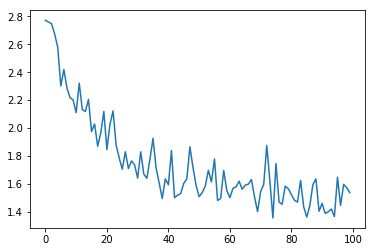

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_test_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




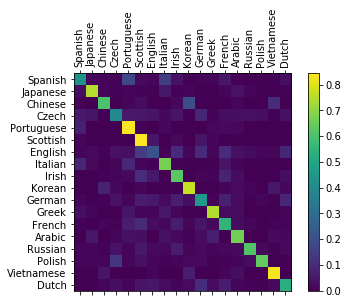

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()



In [15]:
# Keep track of correct guesses in a confusion matrix

n_true_prds = 0
total = 0
      
for category in all_categories:
  for line in test_data[category]:
    line_tensor = lineToTensor(line)
    output = evaluate(line_tensor)
    idx = output.topk(1).indices[0][0].numpy()
    if all_categories[idx] == category:
      n_true_prds += 1
    
    total += 1
    
test_accuracy_Linear = (n_true_prds/total)*100      
print(test_accuracy_Linear, 'Final test accuracy for Linear Model')

54.134399200599546 Final test accuracy for Linear Model


You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.79) Russian
(-1.06) Czech
(-1.89) English

> Jackson
(-0.31) Scottish
(-1.60) English
(-3.67) Russian

> Satoshi
(-1.15) Arabic
(-1.46) Japanese
(-1.68) Italian


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network




# Q1.a
#### GRU Model

In [17]:
import torch.nn as nn
from torch.autograd import Variable

class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_GRU, self).__init__()

        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size, hidden_size, 1)
        self.gru2out = nn.Linear(hidden_size, output_size)
        self.Softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = output[-1]
        output = self.gru2out(output)
        output = self.Softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

n_hidden = 128
rnn_GRU = RNN_GRU(n_letters, n_hidden, n_categories)
print(rnn_GRU)



# category, line, category_tensor, line_tensor = randomTrainingExample()
# hidden = rnn_GRU.initHidden()
# output, hidden = rnn_GRU(line_tensor, hidden)
# print(output)

RNN_GRU(
  (gru): GRU(57, 128)
  (gru2out): Linear(in_features=128, out_features=18, bias=True)
  (Softmax): LogSoftmax()
)


In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

optimizer = optim.Adam(rnn_GRU.parameters(), lr=learning_rate) #for defining my optimizer when not using train_GRU

def train_GRU(category_tensor, line_tensor):
    hidden = rnn_GRU.initHidden()

    rnn_GRU.zero_grad()

    output, hidden = rnn_GRU(line_tensor, hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()
    
    # Add parameters' gradients to their values, multiplied by learning rate
#     for p in rnn_GRU.parameters():
#         p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [19]:
import time
import math
from torch import optim

n_iters = 100000
print_every = 5000
plot_every = 1000

#myLearning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn


# Keep track of losses for plotting
current_loss = 0
all_losses_GRU = []
all_test_losses_GRU = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_GRU(line_tensor):
    hidden = rnn_GRU.initHidden()
    output, hidden = rnn_GRU(line_tensor, hidden)
    return output



start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    
    output, loss = train_GRU(category_tensor, line_tensor)
    
#     hidden = rnn_GRU.initHidden()
#     rnn_GRU.zero_grad()
#     output, hidden = rnn_GRU(line_tensor, hidden)
#     loss = criterion(output, category_tensor)
#     loss.backward()
#     #optimizer.step()
#     loss = loss.item()

    current_loss += loss
 
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_GRU.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate_GRU(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_test_losses_GRU.append(test_loss.item() / n_test_instances)


5000 5% (0m 39s) 0.0012 O'Neill / Irish ✓
10000 10% (1m 24s) 1.0305 Mckay / Scottish ✗ (Irish)
15000 15% (2m 10s) 0.5209 Ho / Vietnamese ✓
20000 20% (2m 55s) 0.4166 Broz / Polish ✓
25000 25% (3m 40s) 0.1336 Bonnay / French ✓
30000 30% (4m 25s) 1.9238 Hopes / Arabic ✗ (English)
35000 35% (5m 11s) 0.1336 Rodrigues / Portuguese ✓
40000 40% (6m 3s) 0.5573 Avksentievski / Russian ✓
45000 45% (6m 48s) 0.0391 Divnich / Russian ✓
50000 50% (7m 33s) 0.0003 Obinata / Japanese ✓
55000 55% (8m 19s) 0.1049 Harlanov / Russian ✓
60000 60% (9m 4s) 0.1337 Milne / Scottish ✓
70000 70% (10m 35s) 0.0000 Lim  / Korean ✓
75000 75% (11m 21s) 0.0359 Krantz / Dutch ✓
80000 80% (12m 6s) 2.7091 Han / Korean ✗ (Vietnamese)
85000 85% (12m 52s) 0.0122 Murray / Scottish ✓
90000 90% (13m 38s) 1.5332 Agamoff / German ✗ (Russian)
95000 95% (14m 23s) 0.8692 Pender / Czech ✗ (Dutch)
100000 100% (15m 8s) 0.0001 Kolijn / Dutch ✓


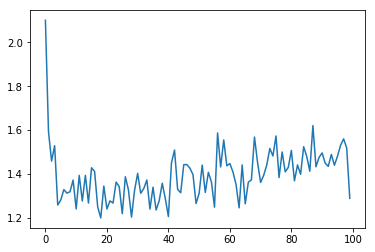

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_test_losses_GRU)

**Evaluating the Result of GRU Model**

In [21]:
# Keep track of correct guesses in a confusion matrix

n_true_prds = 0
total = 0
      
for category in all_categories:
  for line in test_data[category]:
    line_tensor = lineToTensor(line)
    output = evaluate_GRU(line_tensor)
    idx = output.topk(1).indices[0][0].numpy()
    if all_categories[idx] == category:
      n_true_prds += 1
    
    total += 1
    
      
test_accuracy_GRU = (n_true_prds/total)*100      
print(test_accuracy_GRU, 'Final test accuracy for GRU Model')

65.77566824881339 Final test accuracy for GRU Model


**LSTM Model**

In [22]:
import torch.nn as nn
from torch.autograd import Variable

class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, 1)
        self.lstm2out = nn.Linear(hidden_size, output_size)
        self.Softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        output, (hidden, cell) = self.lstm(input, (hidden, cell))
        output = output[-1]
        output = self.lstm2out(output)
        output = self.Softmax(output)
        return output, (hidden, cell)

    def initStates(self):
        return torch.zeros(1, 1, self.hidden_size)
    

n_hidden = 128
rnn_LSTM = RNN_LSTM(n_letters, n_hidden, n_categories)
print(rnn_LSTM)



# category, line, category_tensor, line_tensor = randomTrainingExample()
# hidden = rnn_LSTM.initStates()
# print(hidden)
# cell = rnn_LSTM.initStates()
# print(cell)
# output, (hidden, cell) = rnn_LSTM(line_tensor, hidden, cell)
# print(output)

RNN_LSTM(
  (lstm): LSTM(57, 128)
  (lstm2out): Linear(in_features=128, out_features=18, bias=True)
  (Softmax): LogSoftmax()
)


In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

optimizer = optim.Adam(rnn_LSTM.parameters(), lr=learning_rate) #for defining my optimizer when not using train_GRU

def train_LSTM(category_tensor, line_tensor):
    hidden = rnn_LSTM.initStates()
    cell = rnn_LSTM.initStates()

    rnn_LSTM.zero_grad()

    output, (hidden, cell) = rnn_LSTM(line_tensor, hidden, cell)

    loss = criterion(output, category_tensor)
    loss.backward()
    
    optimizer.step()

#     # Add parameters' gradients to their values, multiplied by learning rate
#     for p in rnn_LSTM.parameters():
#         p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [24]:
import time
import math
from torch import optim

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses_LSTM = []
all_test_losses_LSTM = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_LSTM(line_tensor):
    hidden = rnn_LSTM.initStates()
    cell = rnn_LSTM.initStates()
    output, (hidden, cell) = rnn_LSTM(line_tensor, hidden, cell)
    return output



start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    
    output, loss = train_LSTM(category_tensor, line_tensor)
    
    current_loss += loss
 
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_LSTM.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate_LSTM(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_test_losses_LSTM.append(test_loss.item() / n_test_instances)


5000 5% (0m 42s) 1.7663 Rim / Scottish ✗ (Korean)
10000 10% (1m 34s) 0.1419 Mccallum / Scottish ✓
15000 15% (2m 28s) 0.1061 Czajka / Polish ✓
20000 20% (3m 15s) 1.8684 Munro / Spanish ✗ (Scottish)
25000 25% (4m 2s) 1.2162 Kruse / Japanese ✗ (German)
30000 30% (4m 50s) 0.5281 Mayuzumi / Japanese ✓
35000 35% (5m 38s) 0.0294 Ta / Vietnamese ✓
40000 40% (6m 25s) 0.2132 Everton / English ✓
45000 45% (7m 13s) 1.4129 Koziol / Czech ✗ (Polish)
50000 50% (8m 1s) 0.0025 Coupe / French ✓
55000 55% (8m 49s) 0.5126 Niftrik / Dutch ✓
60000 60% (9m 37s) 0.0598 Blaise / French ✓
65000 65% (10m 26s) 0.0384 Bazzi / Arabic ✓
70000 70% (11m 14s) 0.0074 Pozzi / Italian ✓
75000 75% (12m 4s) 0.3311 Broomfield / English ✓
80000 80% (12m 52s) 0.0105 Aiza / Spanish ✓
85000 85% (13m 41s) 3.2347 Kruckel / Dutch ✗ (German)
90000 90% (14m 29s) 1.7792 Schwarz / Polish ✗ (German)
95000 95% (15m 18s) 0.6421 Rallis / Greek ✓
100000 100% (16m 6s) 0.0001 Chuvyrov / Russian ✓


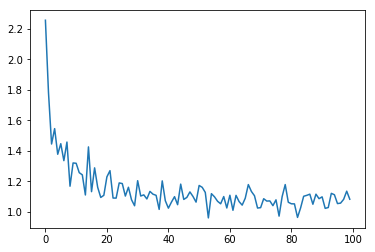

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_test_losses_LSTM)

In [26]:
# Keep track of correct guesses in a confusion matrix

n_true_prds = 0
total = 0
      
for category in all_categories:
  for line in test_data[category]:
    line_tensor = lineToTensor(line)
    output = evaluate_LSTM(line_tensor)
    idx = output.topk(1).indices[0][0].numpy()
    if all_categories[idx] == category:
      n_true_prds += 1
    
    total += 1
    
      
test_accuracy_LSTM = (n_true_prds/total)*100      
print(test_accuracy_LSTM, 'Final test accuracy for GRU Model')


71.72120909318012 Final test accuracy for GRU Model


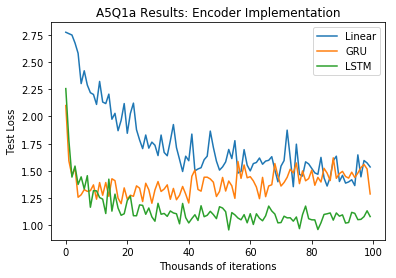

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_test_losses, label = 'Linear')
plt.plot(all_test_losses_GRU, label = 'GRU')
plt.plot(all_test_losses_LSTM, label = 'LSTM')
plt.title('A5Q1a Results: Encoder Implementation')
plt.ylabel('Test Loss')
plt.xlabel('Thousands of iterations')
plt.legend()
plt.legend()

### Explanation of the results

In the follwing cell the comparison between the final accuracy of (1) Linear, (2) GRU, and (3) LSTM models are presented. As can be seen in the graphs, as well, the best performance is for the RNN using LSTM cell, then comes the model with GRU cell, and finally the Linear model ranked 3rd.  That's partly because of considerating $memorization$ and $forgetting$ gates in LSTM and GRU cells. In addition, architecture of these cells enable them to mitigate $gradient$ $vanishig$. Although both GRU and LSTM cells have have the mentioned properties, their comparative performance is problem-related. For the case of this problem, LSTM has better performance than GRU.  

I should mention that I changed the optimization method to $adams$ for GRU and LSTM models. The perforance could be improved even more by adjusting the parameters of optimizer e.g., learning rate.


In [28]:
print(test_accuracy_Linear, 'Final test accuracy for Linear Model')
print(test_accuracy_GRU, 'Final test accuracy for GRU Model')
print(test_accuracy_LSTM, 'Final test accuracy for LSTM Model')

54.134399200599546 Final test accuracy for Linear Model
65.77566824881339 Final test accuracy for GRU Model
71.72120909318012 Final test accuracy for LSTM Model
